In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd

from algorithms.utils import train_test_split

from algorithms.ConfusionMatrix import ConfusionMatrix

from algorithms.Gaussian import QuadraticGaussianClassifier, NormalNaiveBayes
from algorithms.NearestNeighbors import NearestCentroidClassifier
from algorithms.Quadratic import QuadraticClassifier

from sklearn.neighbors import KNeighborsClassifier

import logging

logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
df = pd.read_csv("../datasets/default of credit card clients.csv", delimiter=',')
df.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df['Y'].value_counts()

0    23364
1     6636
Name: Y, dtype: int64

In [4]:
data = np.loadtxt("../datasets/default of credit card clients.csv", delimiter=',', skiprows=1)
data.shape

(30000, 25)

In [5]:
def run_experiments(data, times = 100):
    logger.setLevel(logging.CRITICAL)
    models = {
        "NB": NormalNaiveBayes(),
        "CQ(P)": 
            QuadraticClassifier(check_invertibility=True,pinv_mode="pooled"),
        "CQG(P)": 
            QuadraticGaussianClassifier(check_invertibility=True,pinv_mode="pooled"),
        "CQ(F)": 
            QuadraticClassifier(check_invertibility=True,pinv_mode="friedman"),
        "CQG(F)": 
            QuadraticGaussianClassifier(check_invertibility=True,pinv_mode="friedman"),
        "DMC": NearestCentroidClassifier(),
        "KNN(k=11)": KNeighborsClassifier(n_neighbors=11),
#         "KNN(k=11)": KNNClassifier(k=11),
        "NN": KNeighborsClassifier(n_neighbors=1)
#         "NN": NNClassifier()
    }

    acc_results = []
    metrics_results = []
    for model_name in models:
        print("Running model {}".format(model_name))
        model = models[model_name]
        min_score = 101
        max_score = -1

        scores = []
        sensitivities = []
        specificities = []
        precisions = []
        for _ in range(times):
            
            train,test = train_test_split(data,.8, shuffle=True)
            model.fit(train[:,:-1],train[:,-1])
            
            predicted = []
            for x in test[:,:-1]:
                try:
                    y = model.predict(x)
                except Exception:
                    y = model.predict(x.reshape(1, -1))
                    
                if isinstance(y,list):
                    predicted.append(y[0])
                else:
                    predicted.append(y)
                
            conf_matrix = ConfusionMatrix(test[:,-1],predicted)

            sensitivities.append(conf_matrix.sensitivity())
            specificities.append(conf_matrix.specificity())
            precisions.append(conf_matrix.precision())

            score = conf_matrix.accuracy()
            scores.append(score)

            if score > max_score:
                max_score = score

            if score < min_score:
                min_score = score

        mean = np.mean(scores)
        std = np.std(scores)
        median = np.median(scores)

        acc_results.append({
            "1 - Alg": model_name,
            "2 - Média(%)": mean*100,
            "3 - Mediana(%)": median*100,
            "4 - Min/Max(%)": "{:.1f} / {:.1f}".format(min_score*100,max_score*100),
            "5 - Desv. Pad.(%)": std*100
        })
        
        metrics_results.append({
            "1 - Alg": model_name,
            "6 - Sensibilidade(%)": np.mean(sensitivities)*100,
            "7 - Especificidade(%)": np.mean(specificities)*100,
            "8 - Precisão(%)": np.mean(precisions)*100
        })

    return pd.DataFrame(acc_results).round(1), pd.DataFrame(metrics_results).round(1)

In [6]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)


/Users/lucasperes/miniconda3/envs/jupyter/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,70.3,70.9,59.7 / 76.4,3.9
1,CQ(P),70.0,77.8,21.4 / 79.1,19.3
2,CQG(P),62.9,77.7,21.2 / 79.1,24.7
3,CQ(F),77.9,77.9,76.8 / 78.8,0.4
4,CQG(F),63.5,77.8,20.7 / 79.1,24.5
5,DMC,53.6,53.6,51.5 / 55.0,0.7
6,KNN(k=11),76.8,76.8,75.6 / 78.1,0.4
7,NN,68.8,68.9,67.4 / 70.1,0.5


In [7]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,65.7,71.6,40.3
1,CQ(P),14.0,86.0,3.1
2,CQG(P),27.0,73.0,6.0
3,CQ(F),0.0,100.0,0.0
4,CQG(F),26.0,74.0,5.7
5,DMC,67.1,49.7,27.5
6,KNN(k=11),12.5,95.1,42.0
7,NN,28.9,80.2,29.2


## Clusterizando

In [8]:
from sklearn.cluster import KMeans

100
200
300
400
500
600
700
800
900
1000


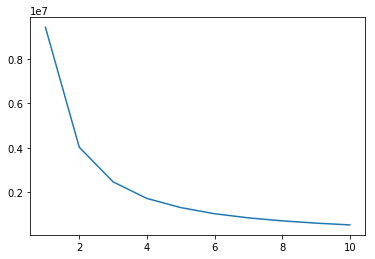

In [9]:
ssds = []
for k in range(100,1001,100):
    d = data[data[:,-1]==0.0]
    print(k)
    model = KMeans(n_clusters=k, max_iter = 10)
    y = model.fit_predict(d[:,:-1])
    ssd = 0
    for x,y in zip(d,y):
        ssd += np.linalg.norm(model.cluster_centers_[y] - x[:-1])
    
    ssds.append(ssd/k)

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.plot(range(1,len(ssds)+1), ssds);

In [10]:
from sklearn.cluster import KMeans

def generate_prototypes(data,k,attempts = 1):
    classes = np.unique(data[:,-1])
    n = data.shape[1]
    clusterized_data = np.reshape(np.zeros(n),(1,n))
    for c in classes:
        prototypes = []
        d = data[data[:,-1]==c]
        for _ in range(attempts):
            model = KMeans(n_clusters=k, max_iter = 10)
            y = model.fit_predict(d[:,:-1])
            ssd = 0
            for x,y in zip(d,y):
                ssd += np.linalg.norm(model.cluster_centers_[y] - x[:-1])
            
            prototypes.append((ssd,model.cluster_centers_))
        
        best_prototype = sorted(prototypes, key= lambda x: x[0])[0][1]
        
        y = np.array([c for _ in range(k)])
        clusterized_data = np.append(clusterized_data,np.c_[best_prototype,y],axis=0)

    return clusterized_data[1:,:]

In [11]:
data = np.loadtxt("../datasets/default of credit card clients.csv", delimiter=',',skiprows=1)
data = generate_prototypes(data, 400)
# np.savetxt("clustered-data-1000.csv",data,delimiter=',')
# data = np.loadtxt("clustered-data-1000.csv",delimiter=',')
data.shape

(800, 25)

In [12]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)
Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,68.9,68.8,59.4 / 78.8,4.1
1,CQ(P),50.2,50.0,40.6 / 61.3,3.8
2,CQG(P),49.6,50.0,38.1 / 55.6,3.4
3,CQ(F),50.1,50.0,39.4 / 59.4,3.8
4,CQG(F),49.9,50.0,41.9 / 56.9,3.2
5,DMC,59.3,58.8,50.0 / 70.6,4.4
6,KNN(k=11),51.9,51.9,45.0 / 59.4,3.1
7,NN,24.3,24.4,18.8 / 30.6,2.7


In [13]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,84.0,54.0,64.6
1,CQ(P),51.0,49.0,25.9
2,CQG(P),47.0,53.0,23.6
3,CQ(F),0.0,100.0,0.0
4,CQG(F),100.0,0.0,49.9
5,DMC,67.5,51.2,57.8
6,KNN(k=11),58.3,46.1,51.3
7,NN,21.2,27.8,23.2


## LDA

In [19]:
data = np.loadtxt("../datasets/default of credit card clients.csv", delimiter=',',skiprows=1)

def statistical_normalization(X):
    m = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    normalized_X = np.zeros((X.shape[0],X.shape[1]))
    for i,x in enumerate(X):
        normalized_X[i] = (x - m)/std
        
    return normalized_X

data[:,:-1] = statistical_normalization(data[:,:-1])

In [20]:
classes = {}
for (x,y) in zip(data[:,:-1],data[:,-1]):
    if not y in classes:
        classes[y] = []

    classes[y].append(x)

classes = {k: np.array(classes[k]) for k in classes}

In [21]:
n = data.shape[1]-1

sw = np.zeros((n,n))
m = np.mean(data[:,:-1],axis=0)
sb = np.zeros((n,n))

for k in classes:
    ni = classes[k].shape[0]
    mi = np.mean(classes[k],axis=0).reshape(n,1)
    mm = mi-m
#     sb += ni*np.outer(mi-m,mi-m)
    sb += ni * mm.dot(mm.T)
    
    s = np.zeros((n,n))
    for x in classes[k]:
        z = (x.reshape(n,1)-mi)
#         s += np.outer(z,z)
        s += z.dot(z.T)
    sw += s
    
sw.shape,sb.shape

((24, 24), (24, 24))

In [22]:
Z = np.linalg.inv(sw).dot(sb)
values, vectors = np.linalg.eig(Z,)

values = np.real(values)
vectors = np.real(vectors)

idx = values.argsort()[::-1]   
values = values[idx]
vectors = vectors[:,idx]

values

array([  3.39780897e+00,   1.64947835e-15,   4.69163593e-16,
         4.69163593e-16,   9.43119860e-17,   5.20827676e-17,
         4.21570204e-17,   4.21570204e-17,   1.57600076e-17,
         4.35527421e-19,   0.00000000e+00,  -1.44799293e-18,
        -1.44799293e-18,  -6.61059612e-18,  -2.22001562e-17,
        -2.22001562e-17,  -5.15544612e-17,  -6.96727862e-17,
        -6.96727862e-17,  -1.54450465e-16,  -4.57577266e-16,
        -4.57577266e-16,  -1.34804604e-15,  -2.98158464e-15])

In [23]:
pca_vectors = vectors[:,0]

data = np.c_[np.matmul(data[:,:-1],pca_vectors), data[:,-1]]
data.shape

(30000, 2)

In [24]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)
Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,81.4,81.5,80.4 / 82.7,0.4
1,CQ(P),73.8,73.7,72.6 / 75.0,0.5
2,CQG(P),78.0,77.9,76.9 / 79.0,0.4
3,CQ(F),73.8,73.8,72.5 / 74.9,0.5
4,CQG(F),77.9,78.0,76.7 / 79.1,0.5
5,DMC,72.4,72.4,70.9 / 73.9,0.6
6,KNN(k=11),80.7,80.7,79.6 / 81.8,0.4
7,NN,71.5,71.6,70.5 / 72.4,0.5


In [25]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,29.7,96.1,68.5
1,CQ(P),58.0,78.3,43.2
2,CQG(P),0.0,100.0,0.0
3,CQ(F),57.9,78.3,43.1
4,CQG(F),0.0,100.0,0.0
5,DMC,60.1,75.9,41.4
6,KNN(k=11),33.4,94.2,61.9
7,NN,35.8,81.7,35.9


In [26]:
data = generate_prototypes(data, 400)
# np.savetxt("clustered-data-1000.csv",data,delimiter=',')
# data = np.loadtxt("clustered-data-1000.csv",delimiter=',')
data.shape

(800, 2)

In [27]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)
Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,60.6,60.6,51.2 / 69.4,3.7
1,CQ(P),61.3,60.6,53.1 / 70.0,3.4
2,CQG(P),51.3,51.9,41.9 / 57.5,3.3
3,CQ(F),60.0,60.0,51.9 / 69.4,3.0
4,CQG(F),49.9,50.0,40.6 / 58.8,3.3
5,DMC,61.2,61.6,51.2 / 71.9,3.8
6,KNN(k=11),51.1,51.2,44.4 / 56.9,2.8
7,NN,14.5,14.4,8.8 / 23.1,2.4


In [28]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,55.9,65.9,62.2
1,CQ(P),55.2,67.3,62.6
2,CQG(P),0.0,100.0,0.0
3,CQ(F),54.5,65.7,61.8
4,CQG(F),0.0,100.0,0.0
5,DMC,55.8,66.8,62.8
6,KNN(k=11),48.4,53.8,51.3
7,NN,15.6,13.5,15.1
